# Lab 8: Regression

Welcome to Lab 8!

Today we will get some hands-on practice with linear regression. You can find more information about this topic in
[section 15.2](https://inferentialthinking.com/chapters/15/2/Regression_Line.html).

In [1]:
# Run this cell, but please don't change it.

# These lines import the Numpy and Datascience modules.
import numpy as np
from datascience import *

# These lines do some fancy plotting magic.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

# These lines load the tests.
from client.api.notebook import Notebook
ok = Notebook('lab08.ok')
_ = ok.auth(inline=True)

Assignment: Regression
OK, version v1.18.1



ERROR  | auth.py:102 | {'error': 'invalid_grant'}



Open the following URL:

https://okpy.org/client/login/

After logging in, copy the code from the web page and paste it into the box.
Then press the "Enter" key on your keyboard.

Paste your code here: 6nRLLl6q2DBIT7j85kaHSXUFLfAibz
Successfully logged in as a00344428@itesm.mx


# 1. How Faithful is Old Faithful? 

(Note: clever title comes from [here](http://web.pdx.edu/~jfreder/M212/oldfaithful.pdf).)

Old Faithful is a geyser in Yellowstone National Park in the central United States.  It's famous for erupting on a fairly regular schedule.  You can see a video below.

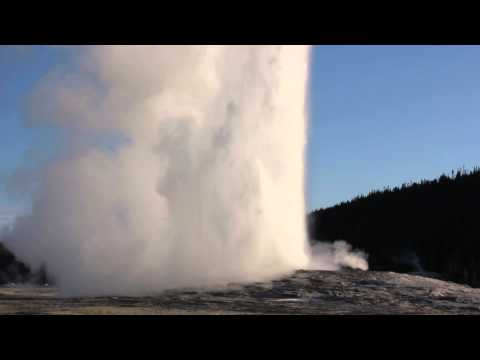

In [2]:
# For the curious: this is how to display a YouTube video in a
# Jupyter notebook.  The argument to YouTubeVideo is the part
# of the URL (called a "query parameter") that identifies the
# video.  For example, the full URL for this video is:
#   https://www.youtube.com/watch?v=wE8NDuzt8eg
from IPython.display import YouTubeVideo
YouTubeVideo("wE8NDuzt8eg")

Some of Old Faithful's eruptions last longer than others.  When it has a long eruption, there's generally a longer wait until the next eruption.

If you visit Yellowstone, you might want to predict when the next eruption will happen, so you can see the rest of the park and come to see the geyser when it happens.  Today, we will use a dataset on eruption durations and waiting times to see if we can make such predictions accurately with linear regression.

The dataset has one row for each observed eruption.  It includes the following columns:
- **duration**: Eruption duration, in minutes
- **wait**: Time between this eruption and the next, also in minutes

Run the next cell to load the dataset.

In [3]:
faithful = Table.read_table("faithful.csv")
faithful

duration,wait
3.6,79
1.8,54
3.333,74
2.283,62
4.533,85
2.883,55
4.7,88
3.6,85
1.95,51
4.35,85


We would like to use linear regression to make predictions, but that won't work well if the data aren't roughly linearly related.  To check that, we should look at the data.

#### Question 1
Make a scatter plot of the data.  It's conventional to put the column we will try to predict on the vertical axis and the other column on the horizontal axis.

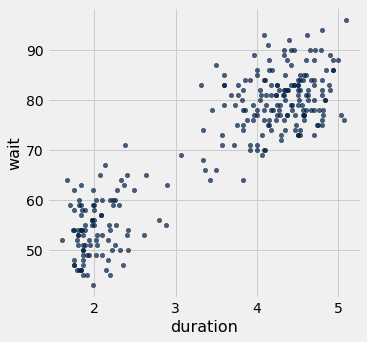

In [4]:
faithful.scatter("duration") 

#### Question 2
Look at the scatter plot. Are eruption duration and waiting time roughly linearly related?  Is the relationship positive, as we claimed earlier?  You may want to consult [the textbook chapter 13](https://www.inferentialthinking.com/chapters/13/prediction.html) for the definition of "linearly related."

There are a rougly linear relation because they are following a line eventhough there are gaps between the data. This relation is positive since is going up. 

We're going to continue with the provisional assumption that they are linearly related, so it's reasonable to use linear regression to analyze this data.

We'd next like to plot the data in standard units.  Recall that, if `nums` is an array of numbers, then

    (nums - np.mean(nums)) / np.std(nums)

...is an array of those numbers in standard units.

#### Question 3
Compute the mean and standard deviation of the eruption durations and waiting times.  **Then** create a table called `faithful_standard` containing the eruption durations and waiting times in standard units.  (The columns should be named `"duration (standard units)"` and `"wait (standard units)"`.

In [6]:
duration_mean = np.mean(faithful.column("duration"))
duration_std = np.std(faithful.column("duration"))
wait_mean = np.mean(faithful.column("wait"))
wait_std = np.std(faithful.column("wait"))

faithful_standard = Table().with_columns(
    "duration (standard units)", (faithful.column("duration")-duration_mean)/duration_std,
    "wait (standard units)", (faithful.column("wait")-wait_mean)/wait_std)
faithful_standard

duration (standard units),wait (standard units)
0.0984989,0.597123
-1.48146,-1.24518
-0.135861,0.228663
-1.0575,-0.655644
0.917443,1.03928
-0.530851,-1.17149
1.06403,1.26035
0.0984989,1.03928
-1.3498,-1.46626
0.756814,1.03928


In [7]:
ok.grade('q1_3');

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 4
Plot the data again, but this time in standard units.

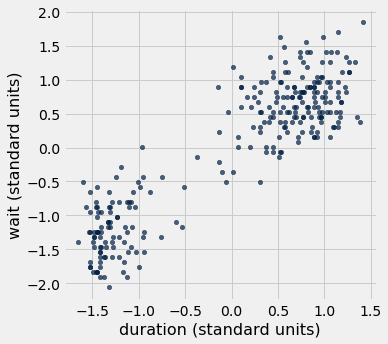

In [8]:
faithful_standard.scatter(0)

You'll notice that this plot looks exactly the same as the last one!  The data really are different, but the axes are scaled differently.  (The method `scatter` scales the axes so the data fill up the available space.)  So it's important to read the ticks on the axes.

#### Question 5
Among the following numbers, which would you guess is closest to the correlation between eruption duration and waiting time in this dataset?

* -1
* 0
* 1

I think 1 since there is a correlation and is positive. 0 is for no correlation at all and -1 is for negative one.

#### Question 6
Compute the correlation `r`.  *Hint:* Use `faithful_standard`.  Section [13.1](https://www.inferentialthinking.com/chapters/13/1/correlation.html) explains how to do this.

In [9]:
r = np.mean(faithful_standard.column(0)*faithful_standard.column(1))
r

0.9008111683218132

In [10]:
ok.grade('q1_6');

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



## 2. The regression line
Recall that the correlation is the slope of the regression line when the data are put in standard units.

The next cell plots the regression line in standard units:

$$\text{waiting time (standard units)} = r \times \text{eruption duration (standard units)}.$$

Then, it plots the original data again, for comparison.

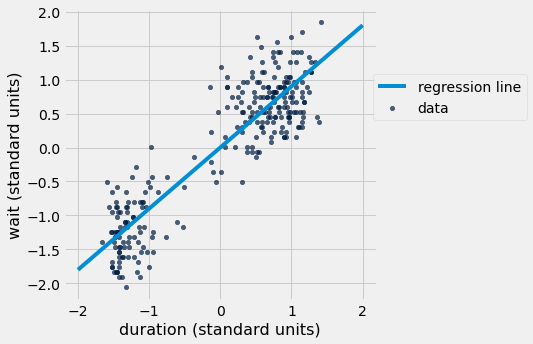

In [11]:
def plot_data_and_line(dataset, x, y, point_0, point_1):
    """Makes a scatter plot of the dataset, along with a line passing through two points."""
    dataset.scatter(x, y, label="data")
    xs, ys = zip(point_0, point_1)
    plots.plot(xs, ys, label="regression line")
    plots.legend(bbox_to_anchor=(1.5,.8))

plot_data_and_line(faithful_standard, 
                   "duration (standard units)", 
                   "wait (standard units)", 
                   [-2, -2*r], 
                   [2, 2*r])

How would you take a point in standard units and convert it back to original units?  We'd have to "stretch" its horizontal position by `duration_std` and its vertical position by `wait_std`.

That means the same thing would happen to the slope of the line.

Stretching a line horizontally makes it less steep, so we divide the slope by the stretching factor.  Stretching a line vertically makes it more steep, so we multiply the slope by the stretching factor.

#### Question 1
What is the slope of the regression line in original units?

(If the "stretching" explanation is unintuitive, consult section [13.2](https://www.inferentialthinking.com/chapters/13/2/regression-line.html) in the textbook.)

In [12]:
slope = (wait_std/duration_std)*r
slope

10.729641395133527

We know that the regression line passes through the point `(duration_mean, wait_mean)`.  You might recall from high-school algebra that the equation for the line is therefore:

$$\text{waiting time} - \verb|wait_mean| = \texttt{slope} \times (\text{eruption duration} - \verb|duration_mean|)$$

After rearranging that equation slightly, the intercept turns out to be:

In [13]:
intercept = slope*(-duration_mean) + wait_mean
intercept

33.47439702275335

In [14]:
ok.grade('q2_1');

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



## 3. Investigating the regression line
The slope and intercept tell you exactly what the regression line looks like.  To predict the waiting time for an eruption, multiply the eruption's duration by `slope` and then add `intercept`.

#### Question 1
Compute the predicted waiting time for an eruption that lasts 2 minutes, and for an eruption that lasts 5 minutes.

In [15]:
two_minute_predicted_waiting_time = 2*slope + intercept
five_minute_predicted_waiting_time = 5*slope + intercept

# Here is a helper function to print out your predictions
# (you don't need to modify it):
def print_prediction(duration, predicted_waiting_time):
    print("After an eruption lasting", duration,
          "minutes, we predict you'll wait", predicted_waiting_time,
          "minutes until the next eruption.")

print_prediction(2, two_minute_predicted_waiting_time)
print_prediction(5, five_minute_predicted_waiting_time)

After an eruption lasting 2 minutes, we predict you'll wait 54.933679813020404 minutes until the next eruption.
After an eruption lasting 5 minutes, we predict you'll wait 87.12260399842098 minutes until the next eruption.


The next cell plots the line that goes between those two points, which is (a segment of) the regression line.

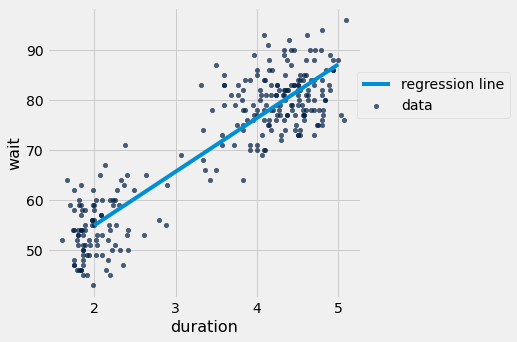

In [16]:
plot_data_and_line(faithful, "duration", "wait", 
                   [2, two_minute_predicted_waiting_time], 
                   [5, five_minute_predicted_waiting_time])

#### Question 2
Make predictions for the waiting time after each eruption in the `faithful` table.  (Of course, we know exactly what the waiting times were!  We are doing this so we can see how accurate our predictions are.)  Put these numbers into a column in a new table called `faithful_predictions`.  Its first row should look like this:

|duration|wait|predicted wait|
|-|-|-|
|3.6|79|72.1011|

*Hint:* Your answer can be just one line.  There is no need for a `for` loop; use array arithmetic instead.

In [17]:
faithful_predictions = faithful.with_column("predicted wait", slope*faithful.column("duration")+intercept)
faithful_predictions

duration,wait,predicted wait
3.6,79,72.1011
1.8,54,52.7878
3.333,74,69.2363
2.283,62,57.9702
4.533,85,82.1119
2.883,55,64.408
4.7,88,83.9037
3.6,85,72.1011
1.95,51,54.3972
4.35,85,80.1483


In [18]:
ok.grade("q3_2");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 3
How close were we?  Compute the *residual* for each eruption in the dataset.  The residual is the actual waiting time minus the predicted waiting time.  Add the residuals to `faithful_predictions` as a new column called `"residual"`, naming the resulting table `faithful_residuals`.

*Hint:* Again, your code will be much simpler if you don't use a `for` loop.

In [19]:
faithful_residuals = faithful_predictions.with_column("residual", faithful_predictions.column(1)-faithful_predictions.column(2))
faithful_residuals

duration,wait,predicted wait,residual
3.6,79,72.1011,6.89889
1.8,54,52.7878,1.21225
3.333,74,69.2363,4.76371
2.283,62,57.9702,4.02983
4.533,85,82.1119,2.88814
2.883,55,64.408,-9.40795
4.7,88,83.9037,4.09629
3.6,85,72.1011,12.8989
1.95,51,54.3972,-3.3972
4.35,85,80.1483,4.85166


In [20]:
ok.grade("q3_3");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



Here is a plot of the residuals you computed.  Each point corresponds to one eruption.  It shows how much our prediction over- or under-estimated the waiting time.

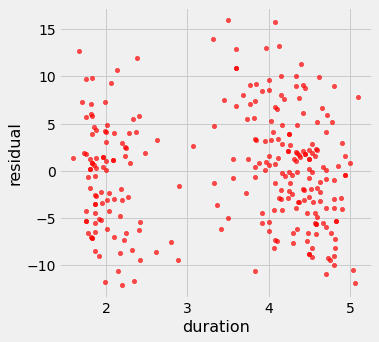

In [21]:
faithful_residuals.scatter("duration", "residual", color="r")

There isn't really a pattern in the residuals, which confirms that it was reasonable to try linear regression.  It's true that there are two separate clouds; the eruption durations seemed to fall into two distinct clusters.  But that's just a pattern in the eruption durations, not a pattern in the relationship between eruption durations and waiting times.

## 4. How accurate are different predictions?
Earlier, you should have found that the correlation is fairly close to 1, so the line fits fairly well on the training data.  That means the residuals are overall small (close to 0) in comparison to the waiting times.

We can see that visually by plotting the waiting times and residuals together:

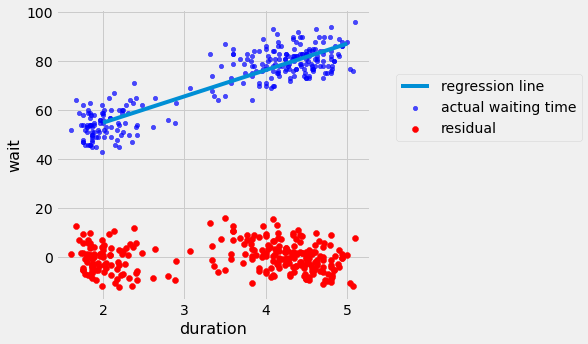

In [22]:
faithful_residuals.scatter("duration", "wait", label="actual waiting time", color="blue")
plots.scatter(faithful_residuals.column("duration"), faithful_residuals.column("residual"), label="residual", color="r")
plots.plot([2, 5], [two_minute_predicted_waiting_time, five_minute_predicted_waiting_time], label="regression line")
plots.legend(bbox_to_anchor=(1.7,.8));

However, unless you have a strong reason to believe that the linear regression model is true, you should be wary of applying your prediction model to data that are very different from the training data.

#### Question 1
In `faithful`, no eruption lasted exactly 0, 2.5, or 60 minutes.  Using this line, what is the predicted waiting time for an eruption that lasts 0 minutes?  2.5 minutes?  An hour?

In [23]:
zero_minute_predicted_waiting_time = intercept
two_point_five_minute_predicted_waiting_time = 2.5*slope + intercept
hour_predicted_waiting_time = 60*slope + intercept

print_prediction(0, zero_minute_predicted_waiting_time)
print_prediction(2.5, two_point_five_minute_predicted_waiting_time)
print_prediction(60, hour_predicted_waiting_time)

After an eruption lasting 0 minutes, we predict you'll wait 33.47439702275335 minutes until the next eruption.
After an eruption lasting 2.5 minutes, we predict you'll wait 60.29850051058717 minutes until the next eruption.
After an eruption lasting 60 minutes, we predict you'll wait 677.252880730765 minutes until the next eruption.


In [24]:
ok.grade('q4_1');

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 2.** Do you believe any of these values are reliable predictions?  If you don't believe some of them, say why.

I don't believe in the 0 minutes wait prediction because it is impossible. The 2.5 minutes wait is belivable since we have data around that value and it looks like the average is near to that prediction. I also don't believe on the 60 minutes wait prediticion since we don't have any data around that value that could verify our prediction or in which we can based on. 

## 5. Divide and Conquer

It appears from the scatter diagram that there are two clusters of points: one for durations around 2 and another for durations between 3.5 and 5. A vertical line at 3 divides the two clusters.

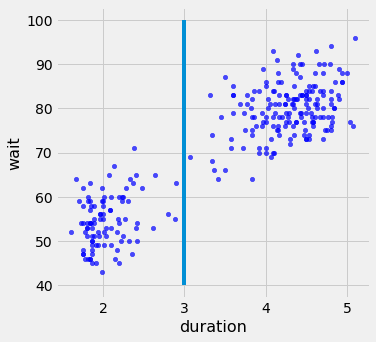

In [25]:
faithful.scatter("duration", "wait", label="actual waiting time", color="blue")
plots.plot([3, 3], [40, 100]);

The `standardize` function from lecture appears below, which returns a table of values in standard units.

In [26]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers)) / np.std(any_numbers)  

def standardize(t):
    """Return a table in which all columns of t are converted to standard units."""
    t_su = Table()
    for label in t.labels:
        t_su = t_su.with_column(label + ' (su)', standard_units(t.column(label)))
    return t_su

**Question 1.** Separately compute the regression coefficients *r* for all the points with a duration below 3 **and then** for all the points with a duration above 3. To do so, create a function that computes `r` from a table and pass it two different tables of points, `below_3` and `above_3`.

In [27]:
def reg_coeff(t):
    """Return the regression coefficient for columns 0 & 1."""
    t_su = standardize(t)
    return np.mean(t_su.column(0)*t_su.column(1))

below_3 = faithful.where("duration", are.below(3))
above_3 = faithful.where("duration", are.above(3))
below_3_r = reg_coeff(below_3)
above_3_r = reg_coeff(above_3)
print("For points below 3, r is", below_3_r, "; for points above 3, r is", above_3_r)

For points below 3, r is 0.2901895264925431 ; for points above 3, r is 0.3727822255707511


In [28]:
ok.grade('q5_1');

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 2.** Write functions `slope_of` and `intercept_of` below. 

When you're done, the functions `wait_below_3` and `wait_above_3` should each use a different regression line to predict a wait time for a duration. The first function should use the regression line for all points with duration below 3. The second function should use the regression line for all points with duration above 3.

In [29]:
def slope_of(t, r):
    """Return the slope of the regression line for t in original units.
    
    Assume that column 0 contains x values and column 1 contains y values.
    r is the regression coefficient for x and y.
    """
    return r*np.std(t.column(1))/np.std(t.column(0))

def intercept_of(t, r):
    """Return the slope of the regression line for t in original units."""
    s = slope_of(t, r)
    return s*(-np.mean(t.column(0)))+np.mean(t.column(1))
    
below_3_a = slope_of(below_3, below_3_r)
below_3_b = intercept_of(below_3, below_3_r)
above_3_a = slope_of(above_3, above_3_r)
above_3_b = intercept_of(above_3, above_3_r)

def wait_below_3(duration):
    return below_3_a * duration + below_3_b

def wait_above_3(duration):
    return above_3_a * duration + above_3_b

In [30]:
ok.grade('q5_2');

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



The plot below shows two different regression lines, one for each cluster!

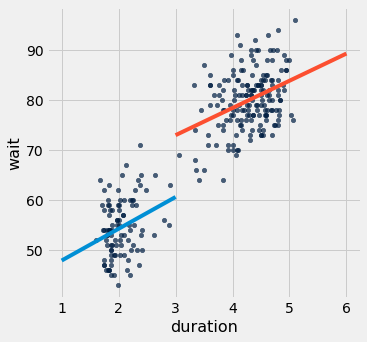

In [31]:
faithful.scatter(0, 1)
plots.plot([1, 3], [wait_below_3(1), wait_below_3(3)])
plots.plot([3, 6], [wait_above_3(3), wait_above_3(6)]);

**Question 3.** Write a function `predict_wait` that takes a `duration` and returns the predicted wait time using the appropriate regression line, depending on whether the duration is below 3 or greater than (or equal to) 3.

In [32]:
def predict_wait(duration):
    """Return the wait predicted by the appropriate one of the two regression lines above."""
    if (duration < 3):
        return wait_below_3(duration)
    else:
        return wait_above_3(duration)

In [33]:
ok.grade('q5_3');

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



The predicted wait times for each point appear below.

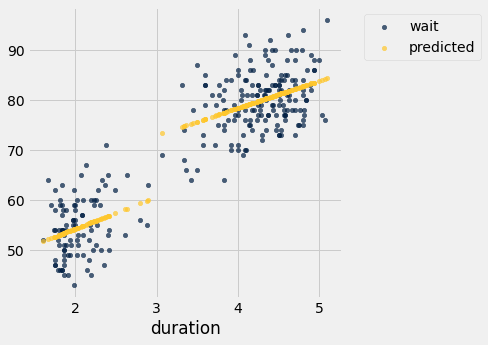

In [34]:
faithful.with_column('predicted', faithful.apply(predict_wait, 'duration')).scatter(0)

**Question 4.** Do you think the predictions produced by `predict_wait` would be more or less accurate than the predictions from the regression line you created in section 2? How could you tell?

I think it would be more accurate since each line is particular to each value in its cluster. 

In [35]:
# For your convenience, you can run this cell to run all the tests at once!
import os
print("Running all tests...")
_ = [ok.grade(q[:-3]) for q in os.listdir("tests") if q.startswith('q')]
print("Finished running all tests.")

Running all tests...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running t

In [36]:
# Run this cell to submit your work *after* you have passed all of the test cells.
# It's ok to run this cell multiple times. Only your final submission will be scored.

_ = ok.submit()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'lab08.ipynb'.
Submit... 100% complete
Submission successful for user: a00344428@itesm.mx
URL: https://okpy.org/tec/tc2031/sp21/lab08/submissions/r9zB66

